# Imports

In [1]:
## Imports ##
import os
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import constant as const
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from utility import check_skew_and_log_effect, continuous_feature_descriptor, save_gridsearch_results, load_gridsearch_results
from feature_selection import FeatureSelectorByModel
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline
from preprocessing import KDD99Preprocessor
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

# Introduction
## Dataset analysis

In [2]:
## Read the dataset and general info ##
df = pd.read_csv("datasets/kddcup99_csv.csv")
df = df.drop_duplicates()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 145586 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145586 non-null  int64  
 1   protocol_type                145586 non-null  object 
 2   service                      145586 non-null  object 
 3   flag                         145586 non-null  object 
 4   src_bytes                    145586 non-null  int64  
 5   dst_bytes                    145586 non-null  int64  
 6   land                         145586 non-null  int64  
 7   wrong_fragment               145586 non-null  int64  
 8   urgent                       145586 non-null  int64  
 9   hot                          145586 non-null  int64  
 10  num_failed_logins            145586 non-null  int64  
 11  logged_in                    145586 non-null  int64  
 12  lnum_compromised             145586 non-null  int64  
 13  lroo

In [3]:
min_samples = 20

value_counts = df['label'].value_counts()
valid_classes = value_counts[value_counts >= min_samples].index
mask = df['label'].isin(valid_classes)

X_filtered = df[mask]
y_filtered = df['label'][mask]

print(X_filtered.info())
print(y_filtered.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 145512 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145512 non-null  int64  
 1   protocol_type                145512 non-null  object 
 2   service                      145512 non-null  object 
 3   flag                         145512 non-null  object 
 4   src_bytes                    145512 non-null  int64  
 5   dst_bytes                    145512 non-null  int64  
 6   land                         145512 non-null  int64  
 7   wrong_fragment               145512 non-null  int64  
 8   urgent                       145512 non-null  int64  
 9   hot                          145512 non-null  int64  
 10  num_failed_logins            145512 non-null  int64  
 11  logged_in                    145512 non-null  int64  
 12  lnum_compromised             145512 non-null  int64  
 13  lroo

In [4]:
# Splitting the dataset to test it in the end
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.25, stratify=y_filtered, random_state=42)

X_train = X_train.drop(columns=['label'])
X_test = X_test.drop(columns=['label'])

In [5]:
## Classes are heavily unbalanced ##
print(X_train.info())
print(y_train.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 109134 entries, 358911 to 79558
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     109134 non-null  int64  
 1   protocol_type                109134 non-null  object 
 2   service                      109134 non-null  object 
 3   flag                         109134 non-null  object 
 4   src_bytes                    109134 non-null  int64  
 5   dst_bytes                    109134 non-null  int64  
 6   land                         109134 non-null  int64  
 7   wrong_fragment               109134 non-null  int64  
 8   urgent                       109134 non-null  int64  
 9   hot                          109134 non-null  int64  
 10  num_failed_logins            109134 non-null  int64  
 11  logged_in                    109134 non-null  int64  
 12  lnum_compromised             109134 non-null  int64  
 13  

## Data Preprocessing

In [6]:
## Checking for anomalies in the metrics ##
continuous_feature_descriptor(X_train)

=== CONTINUOUS FEATURES STATISTICAL ANALYSIS ===

Number of continuous features: 17
Continuous features: ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'lnum_compromised', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

=== DESCRIPTIVE STATISTICS ===
            duration     src_bytes     dst_bytes  wrong_fragment  \
count  109134.000000  1.091340e+05  1.091340e+05   109134.000000   
mean      132.189620  3.174247e+03  2.838697e+03        0.020177   
std      1227.157778  1.054012e+05  6.136063e+04        0.239187   
min         0.000000  0.000000e+00  0.000000e+00        0.000000   
25%         0.000000  0.000000e+00  0.000000e+00        0.000000   
50%         0.000000  1.470000e+02  1.050000e+02        0.000000   
75%         0.000000  2.870000e+02  1.173000e+03        0.000000   
max     58329.000000  5.135678e+06  5.155468e+06

In [7]:
## Check for skewness and apply log transformation if necessary ##
cols = const.CONTINUOUS_COLS

tobelogged = []
for col in cols:
  value = check_skew_and_log_effect(X_train, col)
  if value:
    tobelogged.append(col)
print("Columns to be logged: ", tobelogged)

== duration ==
Skew original: 15.817
Skew log1p   : 5.518
== src_bytes ==
Skew original: 46.162
Skew log1p   : -0.032
== dst_bytes ==
Skew original: 75.546
Skew log1p   : 0.157
== wrong_fragment ==
Skew original: 12.165
Skew log1p   : 11.840
== urgent ==
Skew original: 330.350
Skew log1p   : 330.350
== hot ==
Skew original: 18.089
Skew log1p   : 12.179
== num_failed_logins ==
Skew original: 76.768
Skew log1p   : 54.786
== lnum_compromised ==
Skew original: 220.528
Skew log1p   : 30.254
== lnum_root ==
Skew original: 218.796
Skew log1p   : 22.607
== lnum_file_creations ==
Skew original: 104.181
Skew log1p   : 43.288
== lnum_shells ==
Skew original: 58.373
Skew log1p   : 58.373
== lnum_access_files ==
Skew original: 36.029
Skew log1p   : 19.975
== lnum_outbound_cmds ==
Skew original: nan
Skew log1p   : nan
== count ==
Skew original: 1.307
Skew log1p   : 0.187
== srv_count ==
Skew original: 10.813
Skew log1p   : 0.381
== dst_host_count ==
Skew original: -0.797
Skew log1p   : -1.686
== dst

In [8]:
## Testing the effect of log transformation on skewed features ##
X_copy = X_train.copy()
preprocessor = KDD99Preprocessor()
preprocessor = preprocessor.fit(X_copy)
X_copy = preprocessor.transform(X_copy)

continuous_feature_descriptor(X_copy)

=== CONTINUOUS FEATURES STATISTICAL ANALYSIS ===

Number of continuous features: 20
Continuous features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'lnum_compromised', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

=== DESCRIPTIVE STATISTICS ===
            duration  protocol_type        service           flag  \
count  109134.000000  109134.000000  109134.000000  109134.000000   
mean        0.002266       1.067422      32.144025       6.985770   
std         0.021039       0.310771      13.020918       2.709021   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000      22.000000       5.000000   
50%         0.000000       1.000000      22.000000       9.000000   
75%         0.000000       1.000000      45.000000       9.000000   
max 

In [9]:
# y_multiclass is the multiclass classification target variable
# y_bin is the binary classification target variable
y_multiclass = y_train.copy()
y_bin = y_train.apply(lambda x: 1 if x == 'normal.' else 0)

print(y_bin.value_counts())

label
1    65874
0    43260
Name: count, dtype: int64


# Pipeline study and creation

## Finding best classifier

In [10]:
categorical_cols = const.CATEGORICAL_COLS

Random Forest: F1 macro (CV) = 0.963 ± 0.013
Time taken for Random Forest: 14.95 seconds
Logistic Regression: F1 macro (CV) = 0.659 ± 0.016
Time taken for Logistic Regression: 310.20 seconds
SVM: F1 macro (CV) = 0.849 ± 0.020
Time taken for SVM: 403.76 seconds

Cross-validation results:
                 Model  F1 macro mean  F1 macro std
0        Random Forest       0.963198      0.013300
2                  SVM       0.848991      0.020141
1  Logistic Regression       0.659087      0.015550


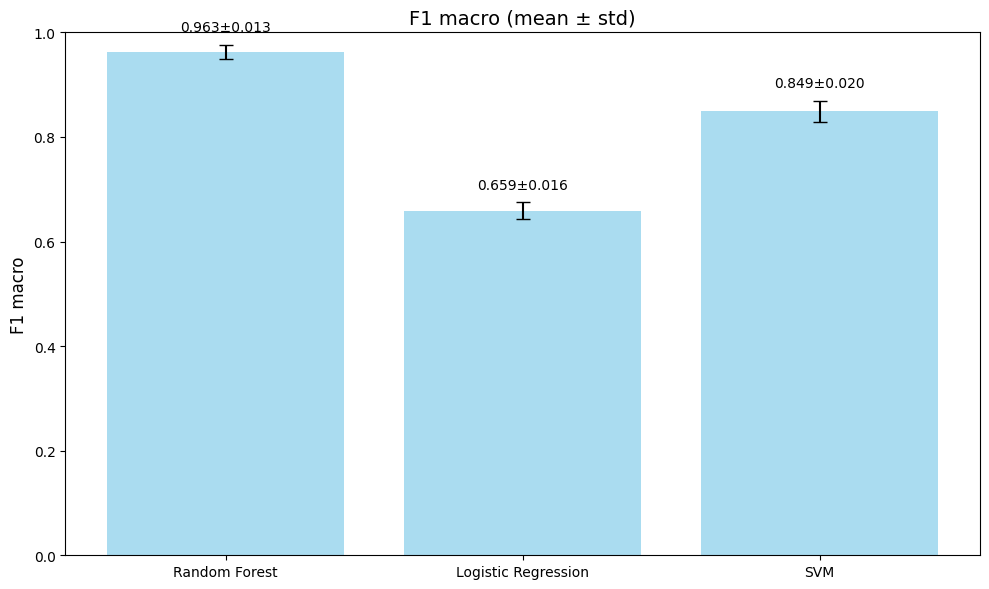

In [11]:
pipelines = {
  "Random Forest": Pipeline([
    ('preprocessing', KDD99Preprocessor()),
    ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3, n_rf_fit=1)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=1))
  ]),
  "Logistic Regression": Pipeline([
    ('preprocessing', KDD99Preprocessor()),
    ('feature_selection', FeatureSelectorByModel(model_type='logreg', n_features=20, n_rf_fit=1)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
  ]),
  "SVM": Pipeline([
    ('preprocessing', KDD99Preprocessor()),
    ('feature_selection', FeatureSelectorByModel(model_type='svm', n_features=20, n_rf_fit=1)),
    ('classifier', LinearSVC(class_weight='balanced', dual=False, max_iter=2000, random_state=42))
  ])
}

# Low number of splits since the dataset is large and we want a rough and quick evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

start = time()
for name, pipe in pipelines.items():
  scores = cross_val_score(pipe, X_train, y_multiclass, cv=skf, scoring='f1_macro', n_jobs=-1)
  results.append({
    "Model": name,
    "F1 macro mean": scores.mean(),
    "F1 macro std": scores.std()
  })
  print(f"{name}: F1 macro (CV) = {scores.mean():.3f} ± {scores.std():.3f}")
  print(f"Time taken for {name}: {time() - start:.2f} seconds")

df_results = pd.DataFrame(results)
print("\nCross-validation results:")
print(df_results.sort_values("F1 macro mean", ascending=False))


plt.figure(figsize=(10, 6))
bars = plt.bar(df_results["Model"], df_results["F1 macro mean"], 
         yerr=df_results["F1 macro std"], capsize=5, alpha=0.7, color='skyblue')
plt.title("F1 macro (mean ± std)", fontsize=14)
plt.ylabel("F1 macro", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)  # Keep model names horizontal

# Add value labels on top of bars with std deviation
for i, (mean, std) in enumerate(zip(df_results["F1 macro mean"], df_results["F1 macro std"])):
  plt.text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Optimization with grid search

### Binary

In [12]:
if os.path.exists("best_rf_params_bin.json"):
  best_params_bin = load_gridsearch_results(prefix="rf", suffix="bin")
else:
  print("File 'best_rf_params_bin.json' not found.")

In [13]:
categorical_cols = [1,2,3]
rf_pipeline = Pipeline([
  ('preprocessing', KDD99Preprocessor()),
  ('smote', SMOTENC(categorical_features=categorical_cols, random_state=42)),
  ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.4, n_rf_fit=1)),
  ('rf', RandomForestClassifier(random_state=42, n_jobs=2))
])

param_grid = {
  'rf__n_estimators': [100, 500],
  'rf__max_depth': [20, None],
  'rf__min_samples_leaf': [1, 5],
}

SAMPLE_SIZE = 10000
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_bin.iloc[sample_idx]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
  rf_pipeline,
  param_grid,
  cv=skf,
  scoring='f1_macro',
  n_jobs=1,
  verbose=2,
  return_train_score=True
)

if 'best_params_bin' not in locals():
  grid.fit(X_train, y_bin)
  best_params_bin = grid.best_params_
else:
  print("Best params already found.")

print("\nBest parameters found:", best_params_bin)

Best params already found.

Best parameters found: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 500}


In [14]:
if 'grid' in locals() and hasattr(grid, 'best_params_'):
  save_gridsearch_results(grid, prefix="rf", suffix="bin")
  print("Grid search results saved successfully.")
else:
  print("Grid search not recalculated and results not found. Skipping save operation.")

Grid search not recalculated and results not found. Skipping save operation.


### Multi

In [15]:
if os.path.exists("best_rf_params_multi.json"):
  best_params_multi = load_gridsearch_results(prefix="rf", suffix="multi")
else:
  print("File 'best_rf_params_multi.json' not found.")

File 'best_rf_params_multi.json' not found.


In [16]:
rf_pipeline = Pipeline([
  ('preprocessing', KDD99Preprocessor()),
  ('smote', SMOTENC(categorical_features=categorical_cols, random_state=42)),
  ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.4, n_rf_fit=1)),
  ('rf', RandomForestClassifier(random_state=42, n_jobs=2))
])

param_grid = {
  'rf__n_estimators': [100, 500],
  'rf__max_depth': [20, None],
  'rf__min_samples_leaf': [1, 5],
}

SAMPLE_SIZE = 10000
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_multiclass.iloc[sample_idx]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
  rf_pipeline,
  param_grid,
  cv=skf,
  scoring='f1_macro',
  n_jobs=3,
  verbose=2,
  return_train_score=True
)

if 'best_params_multi' not in locals():
  grid.fit(X_train, y_multiclass)
  best_params_multi = grid.best_params_
  
else:
  print("Best params already found.")

print("\nBest parameters found:", best_params_multi)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}


In [17]:
if 'grid' in locals() and hasattr(grid, 'best_params_'):
  save_gridsearch_results(grid, prefix="rf", suffix="multi")
  print("Grid search results saved successfully.")
else:
  print("Grid search not recalculated and results not found. Skipping save operation.")

Grid search results saved successfully.


# Binary classification

In [18]:
rf_best_params = {k.replace("rf__", ""): v for k, v in best_params_bin.items()}
pipeline_binary = Pipeline([
  ('preprocessing', KDD99Preprocessor()),
  ('smote', SMOTENC(categorical_features=categorical_cols, random_state=42)),
  ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3)),
  ('rf', RandomForestClassifier(**rf_best_params, random_state=42))
])
# Fit
y_test_bin = y_test.apply(lambda x: 1 if x == 'normal.' else 0)
pipeline_binary.fit(X_train, y_bin)
y_pred = pipeline_binary.predict(X_test)
y_proba = pipeline_binary.predict_proba(X_test)[:,1]  # per ROC/AUC

print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred, target_names=["Attack", "Normal"]))


Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     14420
      Normal       1.00      1.00      1.00     21958

    accuracy                           1.00     36378
   macro avg       1.00      1.00      1.00     36378
weighted avg       1.00      1.00      1.00     36378



## Visualizing results

### Confusion Matrix

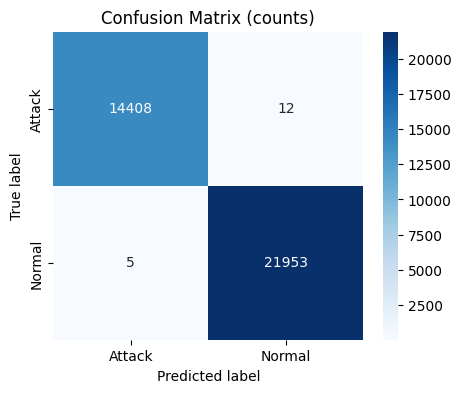

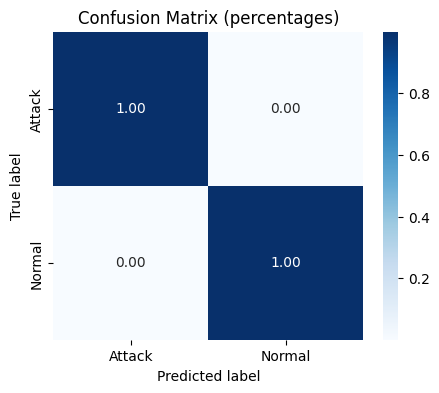

In [19]:
cm = confusion_matrix(y_test_bin, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix (counts)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix (percentages)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


### ROC + AUC

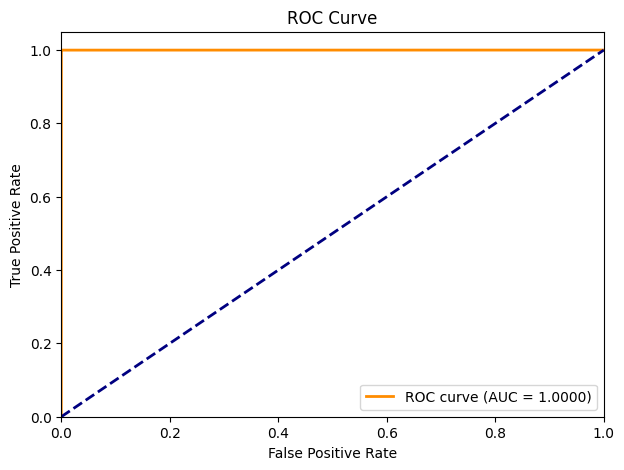

In [20]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Curve

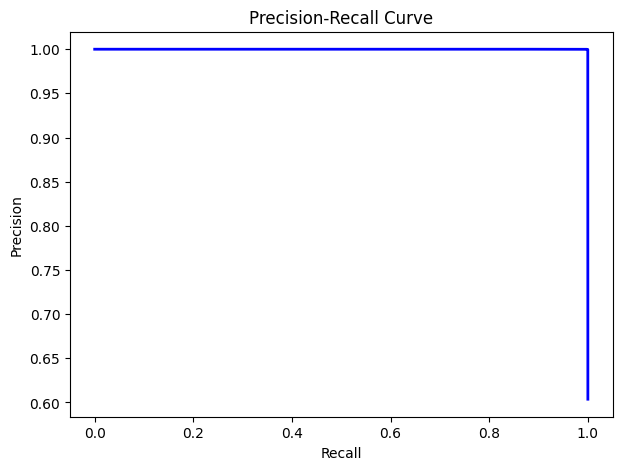

Area under Precision-Recall curve: 1.0000


In [21]:
precision, recall, thresholds_pr = precision_recall_curve(y_test_bin, y_proba)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, lw=2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Area sotto la curva PR
pr_auc = auc(recall, precision)
print(f"Area under Precision-Recall curve: {pr_auc:.4f}")


### Barplot

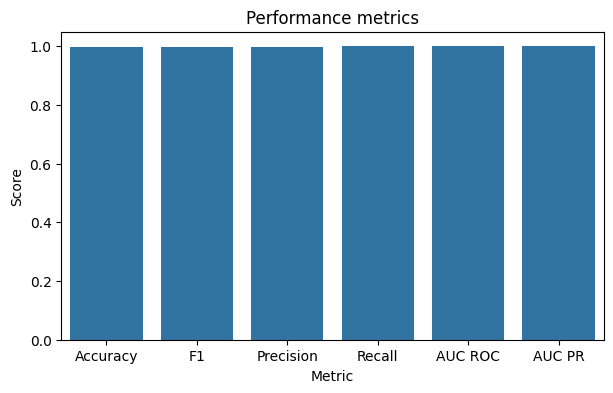

In [22]:
metrics = {
  'Accuracy': accuracy_score(y_test_bin, y_pred),
  'F1': f1_score(y_test_bin, y_pred),
  'Precision': precision_score(y_test_bin, y_pred),
  'Recall': recall_score(y_test_bin, y_pred),
  'AUC ROC': roc_auc,
  'AUC PR': pr_auc
}
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(7,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.ylim(0, 1.05)
plt.title("Performance metrics")
plt.show()


## Multiclass optimization

In [23]:
rf_best_params = {k.replace("rf__", ""): v for k, v in best_params_multi.items()}
pipeline_multiclass = Pipeline([
  ('preprocessing', KDD99Preprocessor()),
  ('smote', SMOTENC(categorical_features=categorical_cols, random_state=42)),
  ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3)),
  ('rf', RandomForestClassifier(**rf_best_params, random_state=42))
])

# Fit
pipeline_multiclass.fit(X_train, y_multiclass)
y_pred = pipeline_multiclass.predict(X_test)
y_proba = pipeline_multiclass.predict_proba(X_test)[:,1]

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("\nConfusion matrix:")
print(cm_df)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels, zero_division=0))


Confusion matrix:
                  back.  buffer_overflow.  guess_passwd.  ipsweep.  neptune.  \
back.               241                 0              0         0         0   
buffer_overflow.      0                 6              0         0         0   
guess_passwd.         0                 0             12         0         0   
ipsweep.              0                 0              0       160         0   
neptune.              0                 0              0         0     12955   
nmap.                 0                 0              0         0         0   
normal.               0                 0              0         0         1   
pod.                  0                 0              0         0         0   
portsweep.            0                 0              0         0         0   
satan.                0                 0              0         0         0   
smurf.                0                 0              0         0         0   
teardrop.            

## Visualizing results

### Confusion matrix normalized

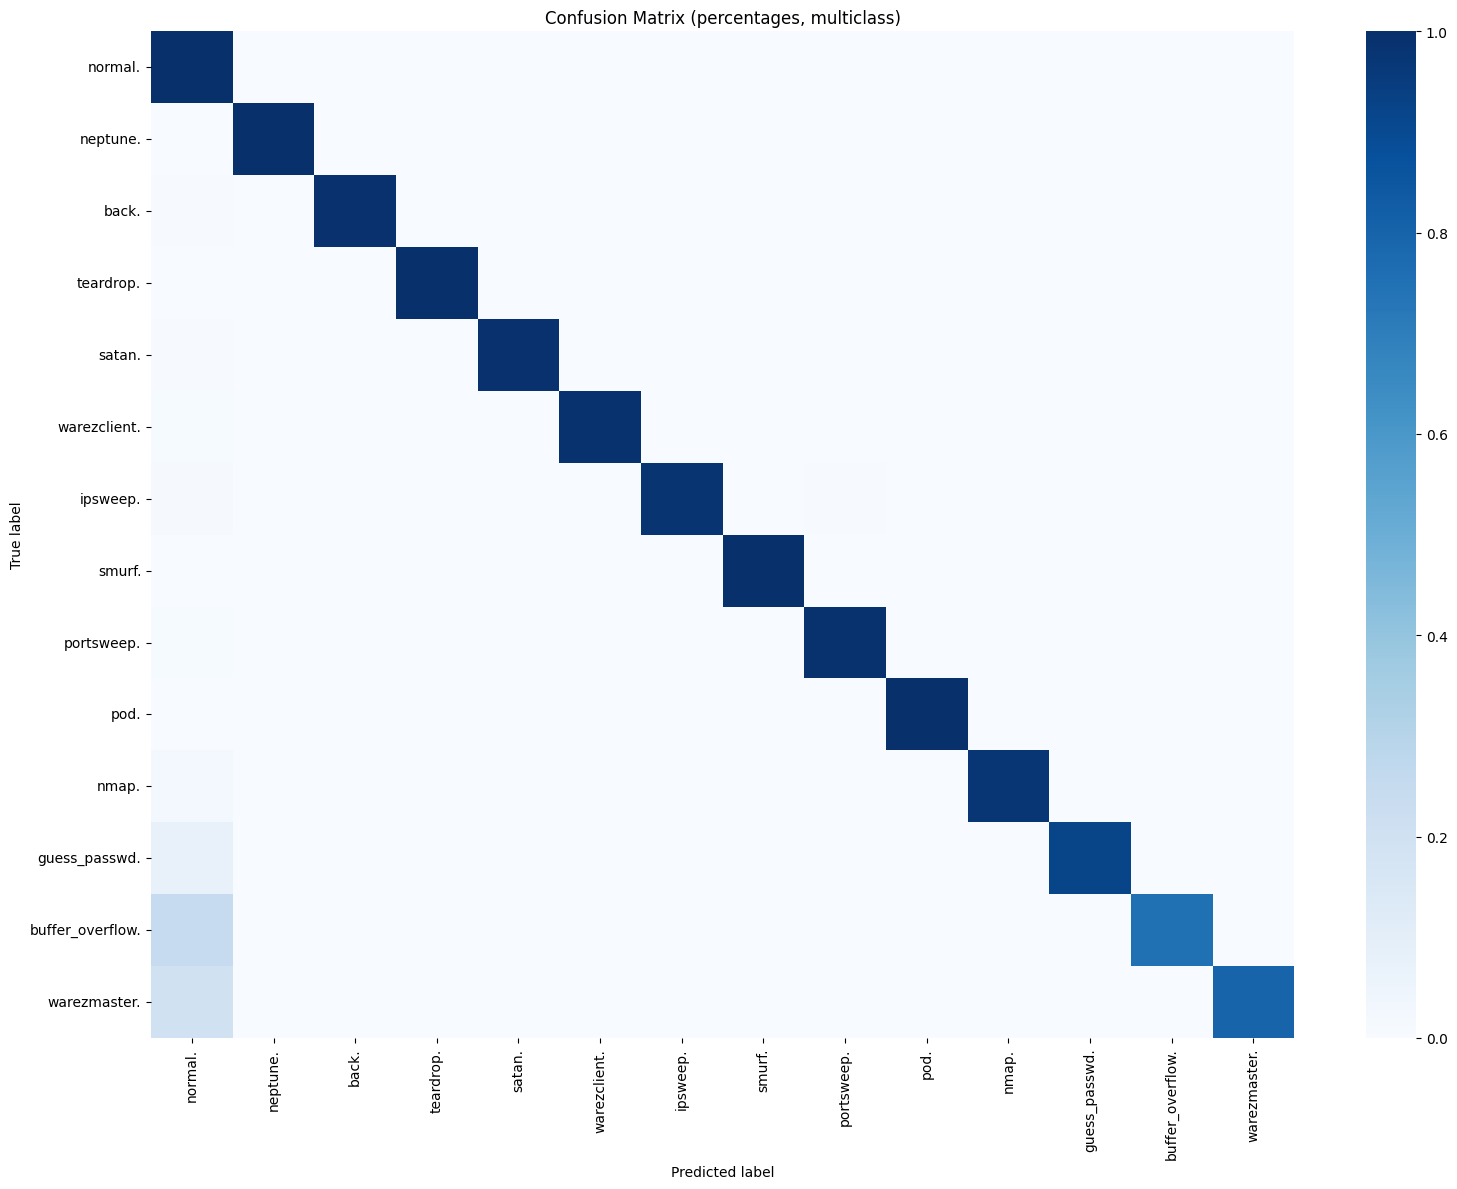

In [24]:
labels_sorted = y_test.value_counts().index.tolist()
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_norm, annot=False, cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("Confusion Matrix (percentages, multiclass)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


### Barplot F1, Precision, Recall per classe

C:\Users\feder\AppData\Local\Temp\ipykernel_30896\2116012154.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1', data=results_df, palette="mako")


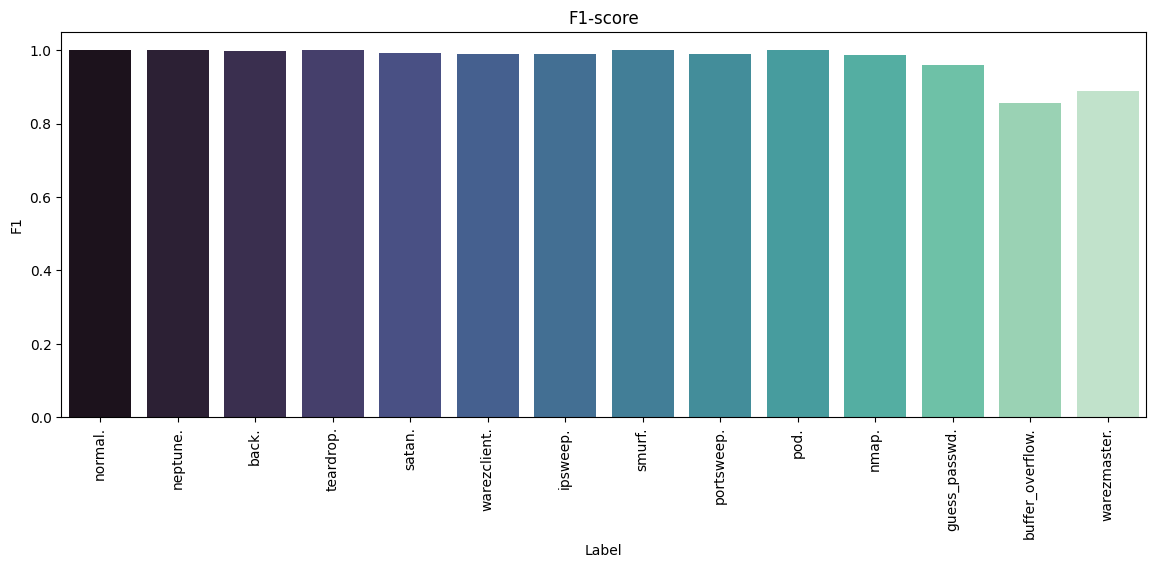

C:\Users\feder\AppData\Local\Temp\ipykernel_30896\2116012154.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")


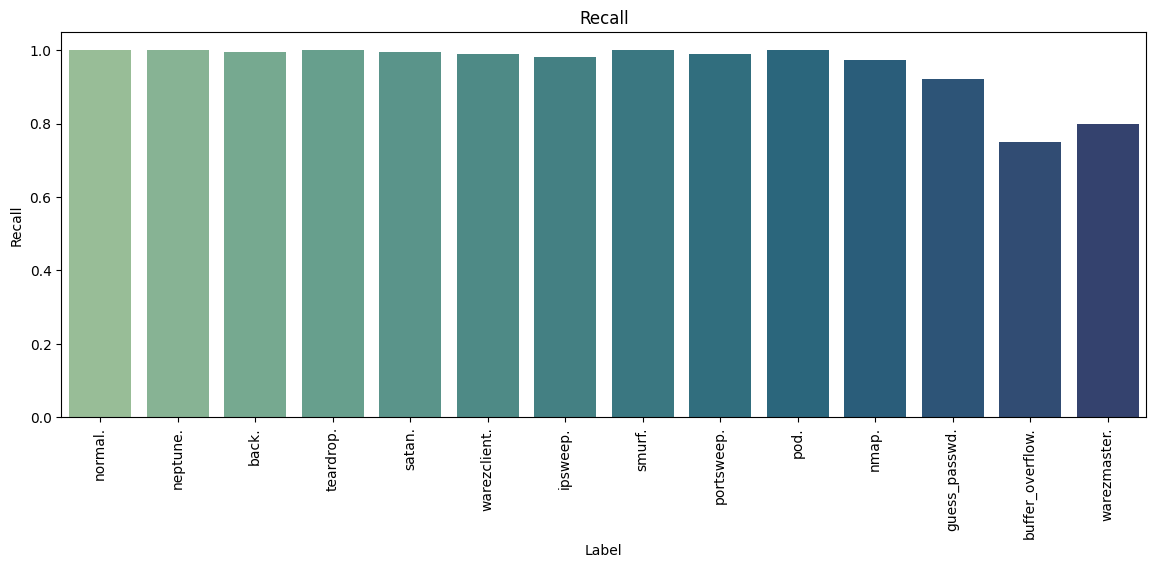

C:\Users\feder\AppData\Local\Temp\ipykernel_30896\2116012154.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")


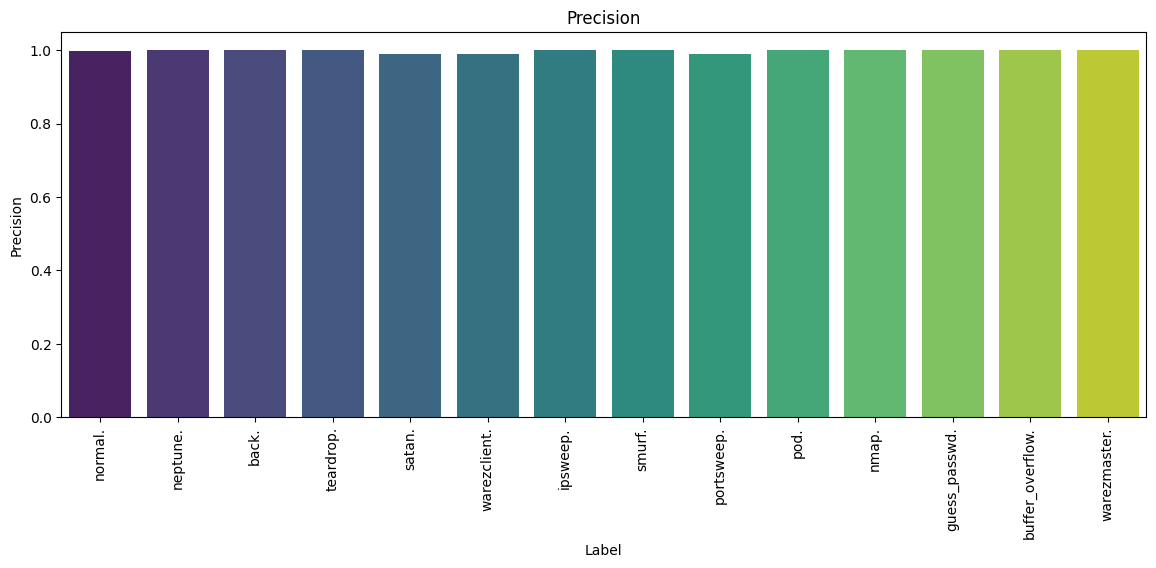

In [29]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=labels_sorted)
results_df = pd.DataFrame({
    'Label': labels_sorted,
    'F1': f1,
    'Precision': precision,
    'Recall': recall,
    'Support': support
})

# Ordina per supporto
results_df = results_df.sort_values('Support', ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='F1', data=results_df, palette="mako")
plt.xticks(rotation=90)
plt.title("F1-score")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")
plt.xticks(rotation=90)
plt.title("Recall")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")
plt.xticks(rotation=90)
plt.title("Precision")
plt.show()


### Micro/macro/weighted average

In [30]:
from sklearn.metrics import f1_score

print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))
print("F1 micro:", f1_score(y_test, y_pred, average="micro"))


F1 macro: 0.975434527020972
F1 weighted: 0.9994987299288949
F1 micro: 0.9995051954477981


### Feature Importance

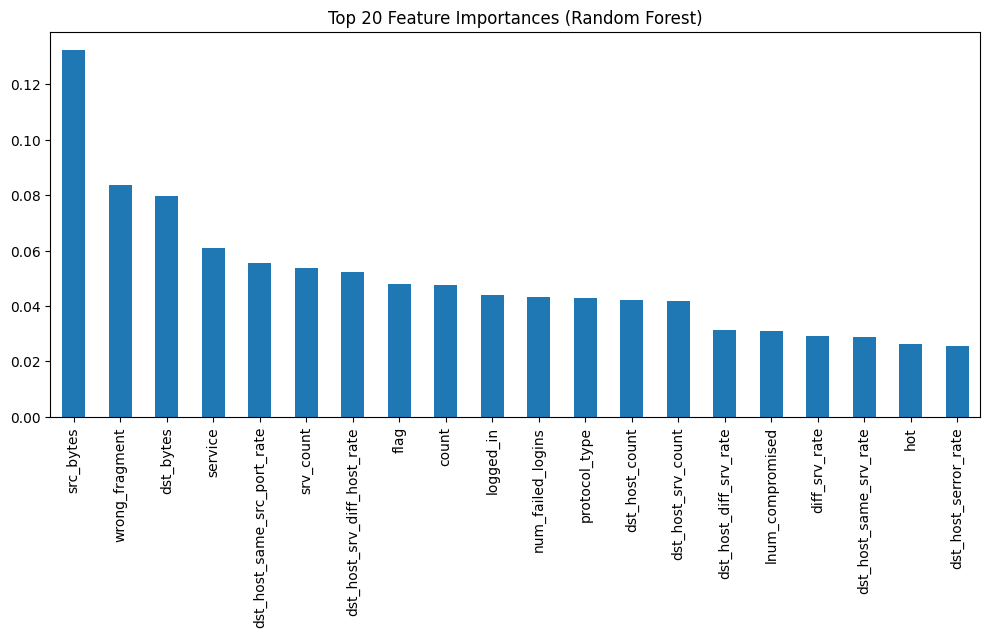

In [31]:
rf = pipeline_multiclass.named_steps['rf']
features = pipeline_multiclass.named_steps['feature_selection'].selected_features_
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(12,5))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


In [ ]:
import joblib
joblib.dump(pipeline_binary, "rf_pipeline_binary.joblib")
joblib.dump(pipeline_multiclass, "rf_pipeline_multiclass.joblib")
print("Pipeline saved succesfully.")

X_test.to_csv("test_set.csv", index=False)
print("Test set saved to test_set.csv")

Pipeline saved succesfully.
Test set saved to test_set.csv
